## Mountain Car Tutorial: Chimp for Beginners
This tutrial provides a step-by-step guide on how to define a simple reinforcement learning problem and use Chimp to solve it. We use the classic [mountain car](https://en.wikipedia.org/wiki/Mountain_Car) problem. In mountain car, you are controlling a car that is trying to get to the top of the hill. The car can accelerate forward, accelerate backwar, or do nothing. The challange lies in the fact that the car can't go directly up the hill (boo gravity), and must learn to move back and forth to get to the top.

If you have a problem that you would like to solve using deep reinforcement learning, there are two things you must define: a simulator and the deep Q-Network (DQN) model. 

## Defining a Simulator Class
The simulator class serves as a generative model that's used by chimp. It provides acess to the dynamics and the reward structures of the problem. 

Your simulator class must contain the following functions:
```python
def act(a): 
    # transitions the simulator by performing the action a
    pass
    
def reward():
    # returns the reward R(s,a) where s is the state before calling act, and a is the action passed to act
    pass
    
def get_screenshot():
    # returns the current state of the system
    pass
    
def episode_over():
    # returns true if the current state is terminal, false otherwise
    pass
    
def reset_episode():
    # reinitializes the current state and reward
    pass

```
Your simulator class must also contain the following fields:
```python
    n_actions # the number of actions availble to the agent
    model_dims # tuple containing the model dimensions for the state of the system
```


In [1]:
# Inline for plotting
%matplotlib inline

In [2]:
##########################################################
################### MOUNTAIN CAR #########################
##########################################################

# you can find this source code in chimp/simulators/mdp/mountain_car.py 
#                              and chimp/simulators/mdp/mdp_simulator.py

import numpy as np

class MountainCar():
    
    def __init__(self,
               term_r = 10.0,
               nonterm_r = -1.0,
               discount = 0.95):
        
        # initialize fields required by Chimp
        self.n_actions = 3
        self.model_dims = (2,)
        
        # initialize simulator vars
        self.current_state = np.zeros(2, dtype=np.float32) # must be float 32
        self.last_reward = 0.0
        
        # initialize mountain car constants
        self.actions = np.array([-1.0, 0.0, 1.0])
        self.vmin, self.vmax = (-0.07, 0.07)
        self.xmin, self.xmax = (-1.2, 0.6)
        self.term_r = term_r
        self.nonterm_r = nonterm_r
        
    def act(self, a):
        """
        Transitions to the next state and computes the reward
        """
        x_old, v_old = self.current_state
        
        # compute the reward
        r = self.term_r if x_old >= self.xmax else self.nonterm_r 
        
        # transition the state
        v = v_old + 0.001 * self.actions[a] - 0.0025 * np.cos(3 * x_old) 
        v = np.clip(v, self.vmin, self.vmax)
        x = x_old + v
        x = np.clip(x, self.xmin, self.xmax)
        
        self.last_reward = r
        self.current_state[0] = x
        self.current_state[1] = v
        
    def reward(self):
        return self.last_reward
        
    def get_screenshot(self):
        return self.current_state
    
    def episode_over(self):
        """
        Checks if the car reached the top of the mountain
        """
        if self.current_state[0] >= self.xmax:
            return True
        return False
    
    def reset_episode(self):
        """
        Reinitializes the state of the car and the last reward
        """
        self.current_state[0] = np.random.uniform(self.xmin, self.xmax*0.9)
        self.current_state[1] = 0.0
        self.last_reward = 0.0
        
    def simulate(self, nsteps, policy):
        """
        Runs a simulation using the provided DQN policy for nsteps
        """
        
        self.reset_episode()
        
        rtot = 0.0
        xpos = np.zeros(nsteps)
        vel = np.zeros(nsteps)
        # state must be in (1, dims) form for forward prop
        input_state = np.zeros((1,2), dtype=np.float32) 
        # run the simulation
        for i in xrange(nsteps):
            state = simulator.get_screenshot()
            input_state[0] = state
            a = policy.action((input_state, None)) # input format for DQN is (state, action), don't use action
            simulator.act(a)
            r = simulator.reward()
            rtot += r
            xpos[i], vel[i] = state
            if simulator.episode_over():
                break
        return rtot, xpos, vel

    
    

## Defining the Deep Q-Network
We use the [Chainer](https://github.com/pfnet/chainer) framework for training and defining the network used for the Q-value apporximation. Currently Chimp only supports Chainer (but TensorFlow support is on its way), so you must define the DQN using the Chainer API. A simple, fully connected network with two hidden layers, batch normalization and ReLU non-linearities looks like this:

In [3]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList

class CarNet(Chain):

    def __init__(self):
        super(CarNet, self).__init__(
            l1=F.Linear(2, 20), # 2 dimensional state space 
            bn1=L.BatchNormalization(20),
            l2=F.Linear(20, 10),
            bn2=L.BatchNormalization(10),
            lout=F.Linear(10, 3) # 3 output actions
        )
        # need this variable for batch normalization and dropout
        self.train = True
        # init avg_var to prevent divide by zero during first forward pass in batch norm
        self.bn1.avg_var.fill(0.1),
        self.bn2.avg_var.fill(0.1),


    def __call__(self, state, a):
        # Chimp passes in actions by defult if requested, not used here
        h = F.relu(self.l1(state))
        h = self.bn1(h, test=not self.train)
        h = F.relu(self.l2(h))
        h = self.bn2(h, test=not self.train)
        output = self.lout(h)
        return output


## Training the Deep Q-Network
Chimp trains the DQN by interfacing with your simulator through a DQNAgent class. Chimp also provides a memory class for storing the replay memory, and a learner class that uses Chainer to do the training. Before starting the training, we have to define some hyper-parameters for the DQN:

In [4]:
settings = {

    # agent settings
    'batch_size' : 32, # size of minibatch
    'print_every' : 1000, # frequency of text output
    'save_dir' : 'results/mountain_car', # everything is saved here
    'iterations' : 2001, # length of training (low value as an example)
    'eval_iterations' : 100, # length of evaluation simulation
    'eval_every' : 1000, # frequnecy of evaluation simulation
    'save_every' : 20000, # frequency of network saving
    'initial_exploration' : 50000, # number of trainstions initally in reaply memory
    'epsilon_decay' : 0.000001, # subtract from epsilon every step
    'eval_epsilon' : 0, # epsilon used in evaluation, 0 means no random actions
    'epsilon' : 1.0,  # Initial exploratoin rate
    'history_sizes' : (1, 0, 0), # sizes of histories to use as nn inputs (s, a, r)
    'model_dims' : (2,),

    # simulator settings
    'viz' : False, # no visualization (used in Atari)

    # replay memory settings
    'memory_size' : 100000,  # size of replay memory

    # learner settings
    'learning_rate' : 0.00001, # learning rate used by the optimizer
    'discount' : 0.95, # discount rate for RL
    'clip_err' : False, # clip gradients
    'clip_reward' : False, # value to clip reward values to
    'target_net_update' : 1000, # frequnecy of target net updates
    'optim_name' : 'ADAM', # currently supports "RMSprop", "ADADELTA", "ADAM" and "SGD"'
    'gpu' : False, # not using GPU
    'reward_rescale': False, # rescale rewards to [0,1]
    'decay_rate' : 0.99, # decay rate for RMSprop, otherwise not used

     # random number seeds
    'seed_general' : 1723,
    'seed_simulator' : 5632,
    'seed_agent' : 9826,
    'seed_memory' : 7563

    }

There are a lot of hyper-parameters, but most of them can be left to the default values. The ones to play around with are: iterations, eval_iteration, epsilon_decay, learning_rate, target_net_update. 

Now we are ready to train the DQN!

In [8]:
# Import the necessary Chimp modules

# Memory
from chimp.memories import ReplayMemoryHDF5

# Learner (Brain)
from chimp.learners.dqn_learner import DQNLearner
from chimp.learners.chainer_backend import ChainerBackend

# Agent Framework
from chimp.agents import DQNAgent

# Policy class for evaluation
from chimp.utils.policies import DQNPolicy

# initialize our mountain car simulator
simulator = MountainCar()

# initialize the netowrk
net = CarNet()

# Initialize the learner with a Chainer backend and out net
backend = ChainerBackend(settings) # initialize with the settings dictionary
backend.set_net(net) # set the net for our Chainer backend
learner = DQNLearner(settings, backend) # create the learner

# Initialize replay memory
memory = ReplayMemoryHDF5(settings)

# Initialize the DQNAgent
agent = DQNAgent(learner, memory, simulator, settings) # pass in all 3 and settings

# Start training
agent.train(verbose=True)

Iteration: 0, Loss: 0.89, Average Q-Values: -0.00, Time since print: 0.04, Total runtime: 0.04, epsilon: 1.00
Evaluation, total reward: -100.00, Reward per episode: -100.00
Iteration: 1000, Loss: 0.53, Average Q-Values: -0.90, Time since print: 49.26, Total runtime: 49.29, epsilon: 1.00
Evaluation, total reward: -100.00, Reward per episode: -100.00
Iteration: 2000, Loss: 0.22, Average Q-Values: -0.84, Time since print: 48.92, Total runtime: 98.21, epsilon: 1.00
Evaluation, total reward: -100.00, Reward per episode: -100.00
Overall training + evaluation time: 98.4197359085


We can plot the training loss. 

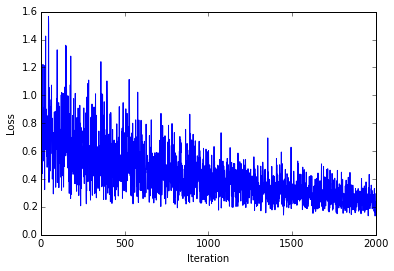

In [9]:
from matplotlib import pyplot
agent.plot_loss()

We can also plot the evaluation history.

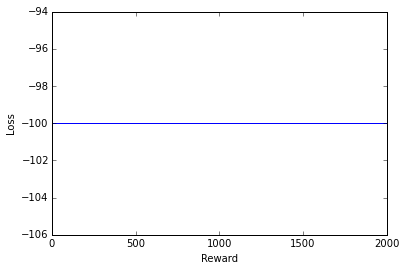

In [10]:
agent.plot_eval_reward()

Nothing interesting is happening yet. Our DQN hasn't learned how to reach the goal state. In fact, mountain car is a diffiuclt problem for reinforcement learning, because of it's sparse reward structure. The only positive reward comes from reaching the top of the mountain. Brute force training takes quite a while to train the DQN on this problem, so we use a pre-trained network. 

## Evaluation
Let's evaluate our pre-trained network. Our pre-trained network had a different architecture. Let's define it and load it.

In [11]:
# re-create our pre-trained network to load it from a pickle file
class TestNet(Chain):

    def __init__(self):
        super(TestNet, self).__init__(
            l1=F.Linear(2, 20, bias=0.0),
            l2=F.Linear(20, 10, bias=0.0),
            bn1=L.BatchNormalization(10),
            l3=F.Linear(10, 10),
            l4=F.Linear(10, 10),
            bn2=L.BatchNormalization(10),
            lout=F.Linear(10, 3)
        )
        self.train = True
        # initialize avg_var to prevent divide by zero
        self.bn1.avg_var.fill(0.1),
        self.bn2.avg_var.fill(0.1),

    def __call__(self, ohist, ahist):
        h = F.relu(self.l1(ohist))
        h = F.relu(self.l2(h))
        h = self.bn1(h, test=not self.train)
        h = F.relu(self.l3(h))
        h = F.relu(self.l4(h))
        h = self.bn2(h, test=not self.train)
        output = self.lout(h)
        return output


Let's load the network.

In [12]:
import pickle
net = pickle.load(open("../chimp/pre_trained_nets/mountain_car.net", "rb"))

We use a simple simulator function to evaluate the DQN:

In [15]:
def car_sim(nsteps, simulator, policy, verbose=False):

    # re-initialize the model
    simulator.reset_episode()

    rtot = 0.0
    xpos = np.zeros(nsteps)
    vel = np.zeros(nsteps)
    # run the simulation
    input_state = np.zeros((1,2), dtype=np.float32)
    for i in xrange(nsteps):
        state = simulator.get_screenshot()
        input_state[0] = state
        a = policy.action((input_state,None))
        simulator.act(a)
        r = simulator.reward()
        rtot += r
        xpos[i], vel[i] = state
        if simulator.episode_over():
            break
    return rtot, xpos, vel

We'll run a quick simulation and collect some statistics.

In [18]:
backend = ChainerBackend(settings)
backend.set_net(net)
learner = DQNLearner(settings, backend)

policy = DQNPolicy(learner)

r, xtrace, vtrace = car_sim(300, simulator, policy, verbose=True)

Now let's plot the positions and velocities. Note that the car reached the terminal state at around 200 time-steps.

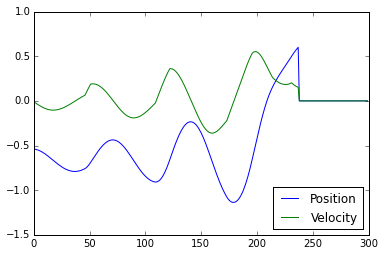

In [20]:
pyplot.plot(xtrace, label='Position'); pyplot.plot(10.0*vtrace, label='Velocity') # scale velcotiy so we can see it
pyplot.legend(loc=4)
pyplot.show()

If you would like to see more examples of using Chimp check out the examples folder. If you want to see more implementations of simulators check out chimp/simulators